# Adult dataset imputation

Data imputation notebook for the Adult dataset

**NOTE**: most of the preliminary analysis (except from the pandas profiling) is done with one of the dataset containing missing values (the 90% one) because we are simulating a real scenario in which the 'perfect' dataset is not available to us.

In [4]:
import pandas as pd
import numpy as np
import utility.dirty_completeness as dc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('darkgrid')
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

import warnings
warnings.simplefilter(action='ignore')

df_adult = pd.read_csv('../datasets/adult.csv')
df_list_adult = dc.injection(df_adult, 1, 'adult', 'income')

df_90 = df_list_adult[4]

saved adult-completeness50%
saved adult-completeness60%
saved adult-completeness70%
saved adult-completeness80%
saved adult-completeness90%


### Data Profiling
First of all we take a look at the dataset to have a better idea of what we are working with 

In [27]:
import pandas_profiling as pp
profile_adult = pp.ProfileReport(df_adult, title="Adult profiling")
#profile_adult.to_file("adult_profiling.html")
profile_adult.to_file("../profilingReports/adult_profiling.json")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 166.16it/s]


In [28]:
import json as j
f = open("../profilingReports/adult_profiling.json")
jfile = j.load(f)

In [7]:
df_adult.head(5)

,age,workclass,fnlwgt,education,education-num,maritial-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42,Self-emp-not-inc,99185,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
1,55,Private,163083,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
2,49,Private,340755,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K
3,31,Private,208881,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
4,19,Private,271446,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,<=50K


Let's take a look at the features to separate categorical and numerical ones.

In [8]:
df_90.nunique()

age                  68
workclass             6
fnlwgt             2595
education            16
education-num        16
maritial-status       7
occupation           13
relationship          6
race                  5
sex                   2
capital-gain         58
capital-loss         37
hours-per-week       73
native-country       38
income                2
dtype: int64

By looking at the `nunique()` output and the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/adult) we can figure out which features are categorical and which are numerical. A good amount of them are numerical but the majority is categorical. We will of course handle them differently in our analysis.


In [9]:
categorical = ['workclass', 'education', 'maritial-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columns = categorical + numerical

### Functional Dependencies

The profiling operation suggested that there were some very simple dependencies that could be explited for the imputation process:

- relationship and sex
    - Husband -> Male
    - Wife -> Female
- education and education-num

Below are some visualizations to verify the hypothesis

NOTE: to do the visualization we use the 90% dataset. The functional dependencies hold true for the other datasets aswell but of course with lower support

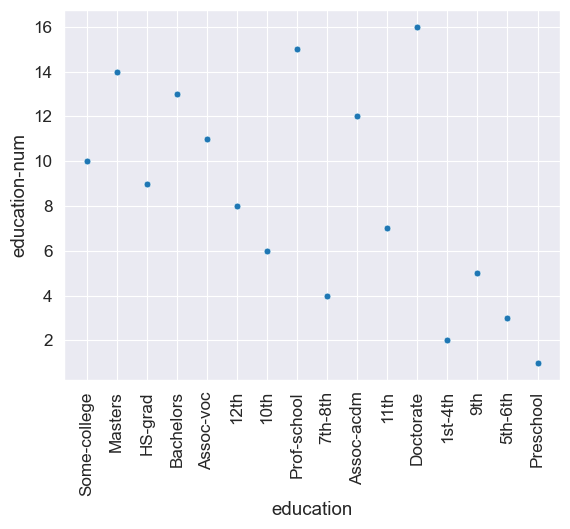

In [10]:
sns.scatterplot(df_90[['education', 'education-num']], x='education', y='education-num')
plt.xticks(rotation=90);

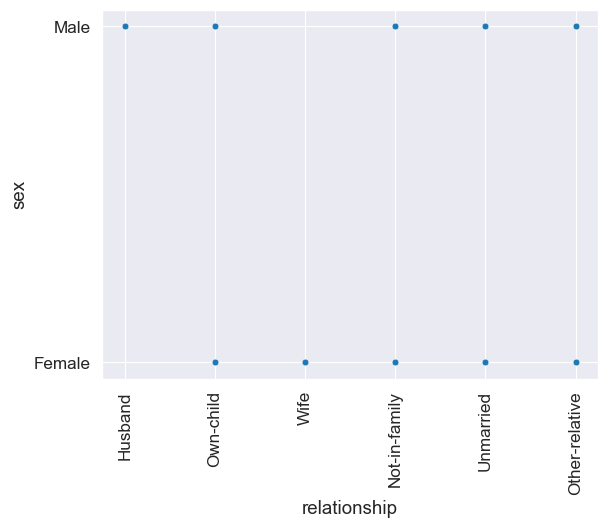

In [11]:
sns.scatterplot(df_90[['relationship', 'sex']], x='relationship', y='sex')
plt.xticks(rotation=90);

for further proof here is the correlation of attributes from the pandasProfiling libraty that clearly shows that: 
- education and education-num are perfectly correlated
- sex and relationship are somewhat correlated

<AxesSubplot:>

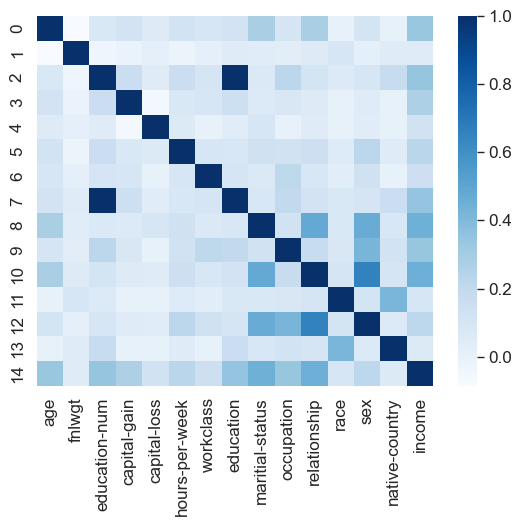

In [12]:
df_correlation = pd.DataFrame(jfile["correlations"]["auto"])
sns.heatmap(df_correlation, cmap='Blues')

now that we discovered the functional dependencies let's create 2 dictionaries that will help us exploit them for the imputation process

In [13]:
sex_dict = {'Husband': 'Male', 'Wife': 'Female'}
inv_sex_dict = {v: k for k, v in sex_dict.items()}
print(sex_dict)
print(inv_sex_dict)

{'Husband': 'Male', 'Wife': 'Female'}
{'Male': 'Husband', 'Female': 'Wife'}


In [14]:
sub_df = df_90[['education', 'education-num']]
sub_df.dropna(inplace=True)
sub_df.drop_duplicates(subset=['education-num'], keep='first', inplace=True)
sub_df.set_index('education-num', inplace=True)
sub_df.sort_index(inplace=True)

temp_dict = sub_df.to_dict()
education_dict = temp_dict['education']
education_dict

{1.0: 'Preschool',
 2.0: '1st-4th',
 3.0: '5th-6th',
 4.0: '7th-8th',
 5.0: '9th',
 6.0: '10th',
 7.0: '11th',
 8.0: '12th',
 9.0: 'HS-grad',
 10.0: 'Some-college',
 11.0: 'Assoc-voc',
 12.0: 'Assoc-acdm',
 13.0: 'Bachelors',
 14.0: 'Masters',
 15.0: 'Prof-school',
 16.0: 'Doctorate'}

In [15]:
#keep also the inverse dictionary
inv_education_dict = {v: k for k, v in education_dict.items()}
inv_education_dict

{'Preschool': 1.0,
 '1st-4th': 2.0,
 '5th-6th': 3.0,
 '7th-8th': 4.0,
 '9th': 5.0,
 '10th': 6.0,
 '11th': 7.0,
 '12th': 8.0,
 'HS-grad': 9.0,
 'Some-college': 10.0,
 'Assoc-voc': 11.0,
 'Assoc-acdm': 12.0,
 'Bachelors': 13.0,
 'Masters': 14.0,
 'Prof-school': 15.0,
 'Doctorate': 16.0}

### Initial imputation using functional dependencies

In [ ]:
# TODO

---

### Simple Imputation

for the simple imputation we are using:
- the median for numerical features
- the most frequent value for categorical features

In [16]:
imputed_df_list = []
for df in df_list_adult:
    # imputate numerical values using the median
    df_numerical = df[numerical].copy()
    simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='median') #define the imputer model
    adult_numerical_imp = simple_imputer.fit_transform(df_numerical) # returns numpy array
    df_numerical_imputed = pd.DataFrame(adult_numerical_imp, columns=numerical)

    # imputate categorical values using the most frequent value
    df_cat = df[categorical].copy()
    simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent') #define the imputer model
    adult_categorical_imp = simple_imputer.fit_transform(df_cat) # returns numpy array
    df_categorical_imputed = pd.DataFrame(adult_categorical_imp, columns=categorical)

    imputed_df = pd.concat([df_numerical_imputed, df_categorical_imputed, df['income']], axis=1)

    imputed_df_list.append(imputed_df)

In [20]:
# check that no NaN is left
for df in imputed_df_list:
    print(df.isnull().sum().sum())

0
0
0
0
0


Now let's evaluate the accuracy of the 5 datasets

In [17]:
from utility.utility import accuracy_assesment

accuracy_assesment(imputed_df_list, df_adult, columns = columns, numeric_columns=numerical)

{'50%': 0.8706605182551194,
 '60%': 0.8939114664858367,
 '70%': 0.922009632789327,
 '80%': 0.9472438291522981,
 '90%': 0.9735564270014484}

---

### Advanced Imputation

For the advanced we are using a modified version of the MICE algorithm seen in class that is able to handle both *regression* and *classification*

In [21]:
from utility.utility import iterative_imputation_KNN

imputed_df_list_advanced = []
for df in df_list_adult:
    imputed_df = iterative_imputation_KNN(df, 'income', numerical)
    imputed_df_list_advanced.append(imputed_df)

loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%


In [25]:
# check that no NaN is left
for df in imputed_df_list_advanced:
    print(df.isnull().sum().sum())

0
0
0
0
0


In [22]:
from utility.utility import accuracy_assesment

accuracy_assesment(imputed_df_list_advanced, df_adult, columns = columns, numeric_columns=numerical)

{'50%': 0.8845461235931402,
 '60%': 0.9106210365309899,
 '70%': 0.9376103940365574,
 '80%': 0.9605105033215388,
 '90%': 0.9803924094318259}

### Final considerations on imputation

The advanced imputation with MICE performs slightly better that the basic one but the computational cost is completely different. 

MICE is about 150x slower than the simple method